In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from datetime import datetime

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Load Mnist data

In [28]:
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

In [3]:
batch_size = 256
# Download the dataset and create the dataloaders

generator1 = torch.Generator().manual_seed(42)
vali_set = torch.utils.data.random_split(mnist_train, [0.2, 0.8], generator=generator1)[0]
train_set = torch.utils.data.random_split(mnist_train, [0.2, 0.8], generator=generator1)[1]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# image_size =28
# Z_dim = 100
# X_dim = image_size*image_size
# # y_dim = train_labels.shape[1]
# h_dim = 128
# c = 0

# Hyperparameters
latent_dim = 100
lr = 1e-3
weight_decay = 1e-4
epochs = 11



# 2.4 CNN

In [4]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # preserves dimension
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # preserves dimension

        # Fully connected layers
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # Reshape input to 28 x 28 x 1
        x = x.view(-1, 1, 28, 28)

        # Convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the output for the dense layers
        x = x.view(-1, 7*7*64)

        # Dense layers with dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)  # Apply dropout only during training
        x = self.fc2(x)

        return x


In [5]:
def train_cnn_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, transform=False):
    best_vloss = 10
    train_loss_lst = []
    vali_loss_lst = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for (inputs, labels) in train_loader:
            # print("train label", labels)
            # inputs_aug = transform(inputs)
            inputs_aug = inputs.to(device)
            labels = labels.to(device)
#             if transform:
#                 inputs_aug = transform_mnist(inputs).to(device)
#             else:
#                 inputs_aug = transform_tensor(inputs).to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs_aug)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / (len(train_loader))

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for (inputs, labels) in val_loader:

#                 if transform:
#                     inputs = transform_mnist(inputs).to(device)
#                 else:
#                     inputs = transform_tensor(inputs).to(device)
#                     inputs = transform_tensor(inputs).to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average validation loss for this epoch
        avg_vloss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_vloss:.4f}")

        if avg_vloss < best_vloss:
            # print("loss is small")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

        train_loss_lst.append(avg_train_loss)
        vali_loss_lst.append(avg_vloss)

    print("Training complete!")
    return model_path, train_loss_lst, vali_loss_lst

In [8]:
model = MNISTCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-5)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
trained_model = train_cnn_model(model, criterion, optimizer, train_loader, vali_loader, 10, False)

Epoch [1/10] - Train Loss: 0.2495 - Val Loss: 0.0618
Epoch [2/10] - Train Loss: 0.0629 - Val Loss: 0.0397
Epoch [3/10] - Train Loss: 0.0442 - Val Loss: 0.0271
Epoch [4/10] - Train Loss: 0.0329 - Val Loss: 0.0175
Epoch [5/10] - Train Loss: 0.0250 - Val Loss: 0.0143
Epoch [6/10] - Train Loss: 0.0223 - Val Loss: 0.0150
Epoch [7/10] - Train Loss: 0.0172 - Val Loss: 0.0129
Epoch [8/10] - Train Loss: 0.0142 - Val Loss: 0.0093
Epoch [9/10] - Train Loss: 0.0152 - Val Loss: 0.0102
Epoch [10/10] - Train Loss: 0.0122 - Val Loss: 0.0086
Training complete!


In [9]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy: %.2f %%' % accuracy)


Accuracy: 99.27 %


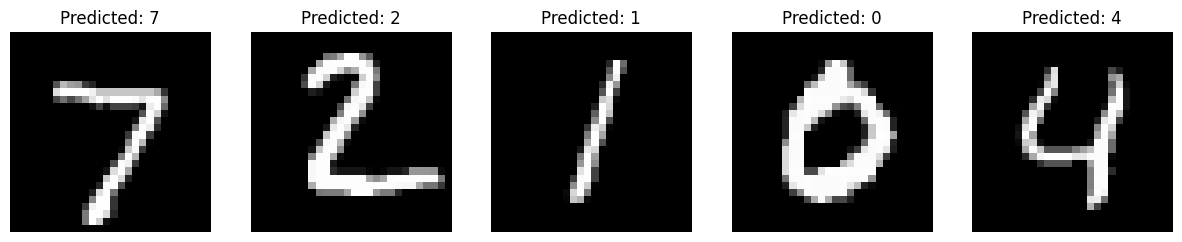

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
output = model(images)
_, preds = torch.max(output, 1)

# Convert image for display
images = images.cpu().numpy()
preds = preds.cpu().numpy()

# Plot
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.squeeze(images[i]), cmap='gray')
    ax[i].set_title(f'Predicted: {preds[i]}')
    ax[i].axis('off')
plt.show()


In [143]:
def create_plot_adversarial_images(model, original_image, target_label, lr=0.1, n_steps=1, output_probs=False):
    model.eval()  # Set model to evaluation mode
    original_image = original_image.to(device)  # Ensure tensor is on the correct device
    target_label = target_label.to(device)
    image_adv = original_image.clone().detach().requires_grad_(True)

    probs_per_step = []
    fig, ax = plt.subplots(n_steps, 2)
    output = model(image_adv)

    loss = torch.nn.functional.cross_entropy(output, target_label)
    # model.zero_grad()
    # loss.backward()
    # data_grad = image_adv.grad.data
    data_grad = torch.autograd.grad(loss,image_adv)[0]

    for _ in range(n_steps):
        # Create adversarial image by adjusting the original image
        image_adv = image_adv + lr * torch.sign(data_grad) / n_steps
        image_adv = image_adv.detach()
        image_adv = torch.clamp(image_adv, 0, 1)  # Clamp to ensure it's still an image

        # Get predictions
        # output = model(image_adv)
        # _, preds = torch.max(output, 1)

        # Convert image for display
        # images = images.cpu().numpy()
        # preds = preds.cpu().numpy()

        if output_probs:
            # Optionally output probabilities
            output = model(image_adv)
            prob = torch.nn.functional.softmax(output, dim=1).detach().cpu().numpy()
            pred = np.argmax(prob,1).item()

            print(prob.squeeze()[pred]*100)
            probs_per_step.append(prob)



        adversarial_image = image_adv.squeeze().detach().cpu().numpy()
        ax[_,0].imshow(original_image.detach().cpu().numpy().reshape(28,28,1), cmap='gray')
        ax[_,0].set_title(f"Adversarial Image with Target Label: {target_label.item()}")
        ax[_,1].imshow(adversarial_image, cmap='gray')
        ax[_,1].set_title(f"Adversarial Image Label: {np.argmax(prob,1).item()}")
    plt.show()
    return image_adv, probs_per_step


4
100.0
99.99998807907104
99.99977350234985
99.99748468399048
99.97257590293884
99.75388050079346
97.86694049835205
84.73971486091614
53.908705711364746
83.3912193775177


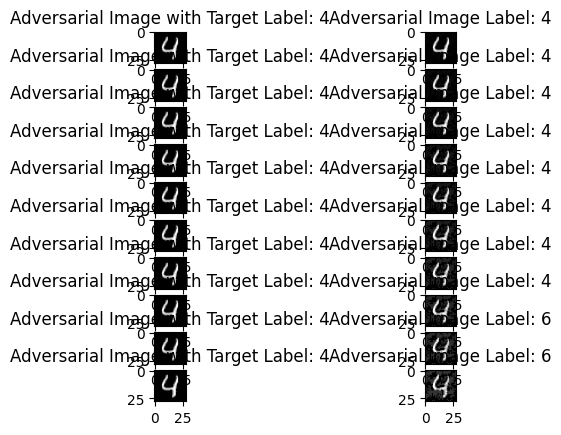

In [149]:
# Assuming you have a DataLoader for MNIST
dataiter = iter(test_loader)
images, labels = next(dataiter)
for i in range(len(labels)):
  if labels[i] == 4:
    org4 = images[i]
    break
print(i)
# Select a single image and label
image, label = images[i:i+1], labels[i:i+1]  # Ensure they are unsqueezed so the batch dimension is present


# Generate adversarial image
adversarial_image, probs_steps = create_plot_adversarial_images(model, image, label, lr=0.2, n_steps=10, output_probs=True)

# # Convert tensor image for visualization
# adversarial_image = adversarial_image.squeeze().detach().cpu().numpy()
# plt.imshow(adversarial_image, cmap='gray')
# plt.title(f"Adversarial Image with Target Label: {label.item()}")
# plt.show()

# Optionally, print probabilities
output_probs=False
if output_probs:
    print("Probabilities per step:", probs_steps)
